# Tomato Disease Classification Model 

This notebook details the development and evaluation of a Convolutional Neural Network (CNN) model for classifying tomato plant diseases. The objective is to accurately identify different types of diseases affecting tomato plants from images.

## Key Components:
1. **Data Preparation**:
   - The dataset consists of images of tomato leaves categorized into different disease classes and one additional class for non-tomato leaves.
   - The images are preprocessed, including resizing and normalization, to ensure uniform input to the CNN model.

2. **Model Architecture**:
   - A CNN architecture is designed, comprising multiple convolutional layers, pooling layers, and fully connected layers.
   - The model leverages techniques like batch normalization to enhance performance and prevent overfitting.

3. **Model Training**:
   - The model is trained using the preprocessed dataset, with techniques like data augmentation applied to increase the diversity of training data.
   - The training process includes monitoring validation performance to adjust hyperparameters and improve accuracy.

4. **Model Evaluation**:
   - The performance of the CNN model is evaluated using metrics such as accuracy, precision, recall, and F1-score.
   - Confusion matrices and classification reports are generated to provide detailed insights into the model's performance across different disease categories.

5. **Class Distinction**:
   - The model is trained to distinguish between healthy and diseased tomato leaves, as well as identifying non-tomato leaves.
   - Specifically, the model can classify the images into five categories: 
     - Healthy
     - Diseased with three specific disease classes
     - Non-tomato leaves

6. **User Interaction**:
   - A Streamlit web application is developed to integrate the trained CNN model, allowing users to upload and classify tomato leaf images in real-time.
   - The application provides instant feedback on the disease classification, aiding in timely disease management.

7. **Visualization**:
   - The model's predictions are visualized through confusion matrices and accuracy plots to assess its reliability.
   - Example predictions are displayed to demonstrate the model's ability to classify different diseases and distinguish between tomato and non-tomato leaves.

This comprehensive approach ensures a robust and efficient tomato disease classification system capable of assisting farmers and agriculturists in managing and mitigating plant diseases.


In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib as plt
import matplotlib.pyplot as plt
import keras
from keras.models import load_model
import numpy as np

In [4]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3


In [5]:
from pathlib import Path
# Path to data directory
data_dir = Path('/content/drive/MyDrive/classification_data/tomato_dataset')

In [6]:
import os
# Get the class names from the directory names
class_names = sorted(os.listdir(data_dir))
# Print the class names
print(class_names)


['Bacterial_spot', 'Early_blight', 'Late_blight', 'Tomato___healthy', 'not_tomato_leaf']


In [7]:
# Function to count images in each class
def count_images_per_class(data_dir):
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            image_count = len([img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))])
            class_counts[class_name] = image_count
    return class_counts

# Get class names and image counts
class_counts = count_images_per_class(data_dir)

#  Print the results
for class_name, count in class_counts.items():
    print(f'Class: {class_name}, Number of images: {count}')

Class: not_tomato_leaf, Number of images: 801
Class: Tomato___healthy, Number of images: 800
Class: Late_blight, Number of images: 800
Class: Early_blight, Number of images: 800
Class: Bacterial_spot, Number of images: 800


In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 4002 files belonging to 5 classes.
Using 3202 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 4002 files belonging to 5 classes.
Using 800 files for validation.


In [10]:
total_samples = tf.data.experimental.cardinality(val_ds)
test_size = total_samples // 2  # 50% of the validation dataset

test_ds = val_ds.take(test_size)
val_ds = val_ds.skip(test_size)


In [11]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of validation batches: 13
Number of test batches: 12


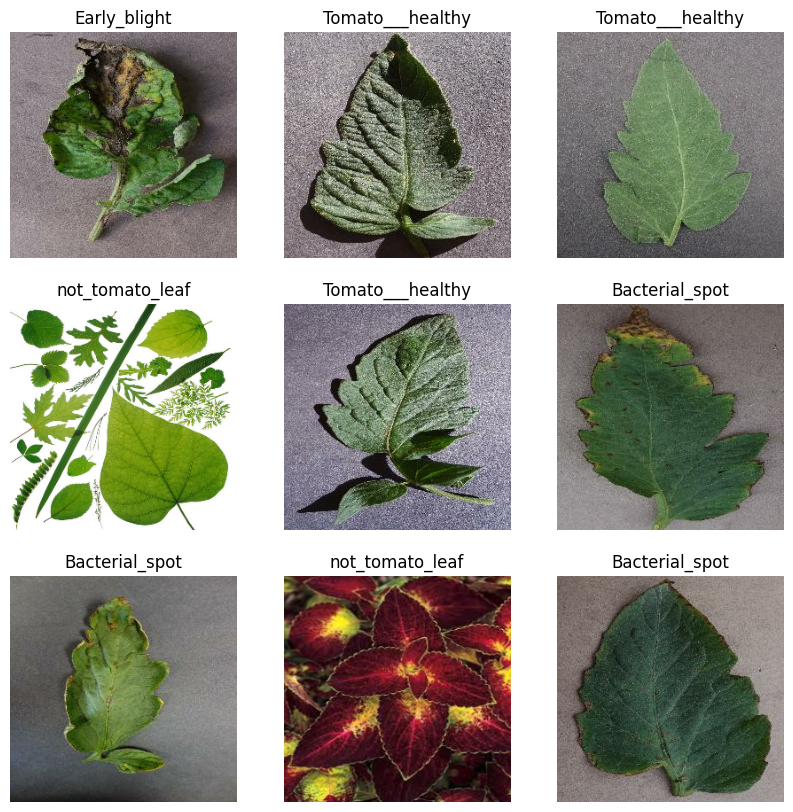

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [14]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)])

In [16]:
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),])

In [17]:
input_shape= (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=5

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [20]:

%%time
epochs = 37
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  verbose=1
)

Epoch 1/37
101/101 [==============================] - 80s 556ms/step - loss: 1.5131 - accuracy: 0.3148 - val_loss: 1.3477 - val_accuracy: 0.4062
Epoch 2/37
101/101 [==============================] - 50s 498ms/step - loss: 1.1061 - accuracy: 0.5350 - val_loss: 0.9809 - val_accuracy: 0.6418
Epoch 3/37
101/101 [==============================] - 50s 497ms/step - loss: 0.8549 - accuracy: 0.6630 - val_loss: 0.7535 - val_accuracy: 0.7163
Epoch 4/37
101/101 [==============================] - 50s 493ms/step - loss: 0.7174 - accuracy: 0.7327 - val_loss: 0.8797 - val_accuracy: 0.6587
Epoch 5/37
101/101 [==============================] - 50s 498ms/step - loss: 0.6333 - accuracy: 0.7614 - val_loss: 0.8235 - val_accuracy: 0.7091
Epoch 6/37
101/101 [==============================] - 50s 498ms/step - loss: 0.5748 - accuracy: 0.7798 - val_loss: 0.7115 - val_accuracy: 0.7476
Epoch 7/37
101/101 [==============================] - 50s 499ms/step - loss: 0.5282 - accuracy: 0.8089 - val_loss: 0.6076 - val_ac

In [21]:
scores= model.evaluate(test_ds)

12/12 [==============================] - 2s 94ms/step - loss: 0.1894 - accuracy: 0.9375


In [22]:
acc= history.history['accuracy']
val_acc=  history.history['val_accuracy']

loss= (history.history['loss'])
val_loss= (history.history['val_loss'])

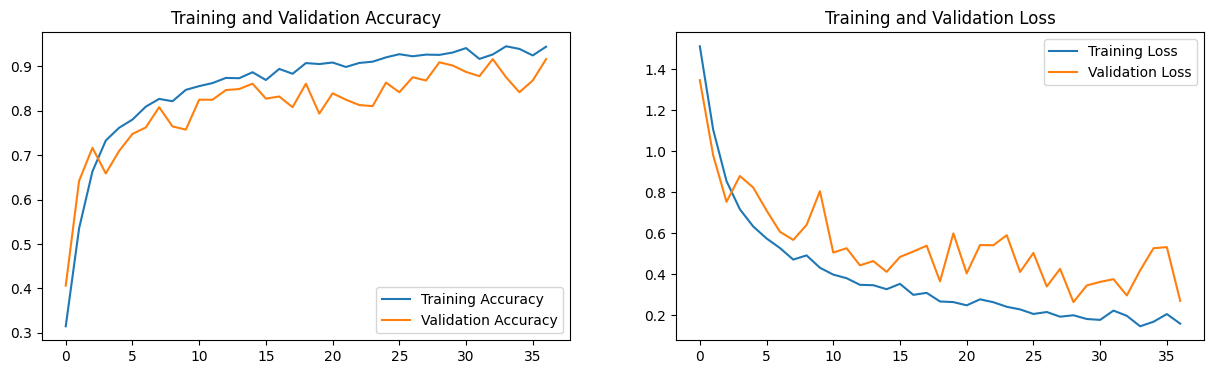

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
# print the final training and validation accuracy + loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# print the final training and validation accuracy + loss
print(f"----{'-'*10}----")
print("Training accuracy: {:.2f}".format(acc[-1]))
print("Validation accuracy: {:.2f}".format(val_acc[-1]))
print(f"----{'-'*10}----")
print("Training loss: {:.2f}".format(loss[-1]))
print("Validation loss: {:.2f}".format(val_loss[-1]))

------------------
Training accuracy: 0.94
Validation accuracy: 0.92
------------------
Training loss: 0.16
Validation loss: 0.27


predict first image
actual label: Late_blight
1/1 [==============================] - 0s 248ms/step
predicted label: Late_blight


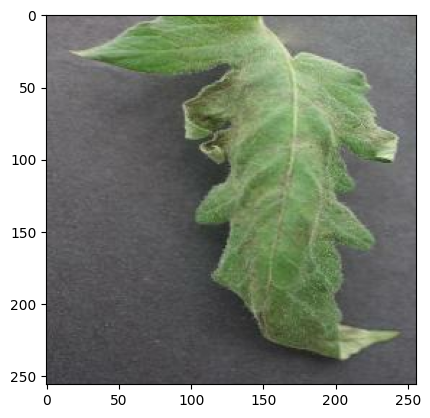

In [25]:


for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    print("predict first image")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])
    batch_prediction=model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])])

In [26]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array, 0) #creates a batch
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 123ms/step
                  precision    recall  f1-score   support

  Bacterial_spot       0.97      0.95      0.96        75
    Early_blight       0.89      0.93      0.91        83
     Late_blight       0.89      0.89      0.89        64
Tomato___healthy       0.98      1.00      0.99        84
 not_tomato_leaf       0.96      0.91      0.93        78

        accuracy                           0.94       384
       macro avg       0.94      0.94      0.94       384
    weighted avg       0.94      0.94      0.94       384

Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1 Score: 0.94


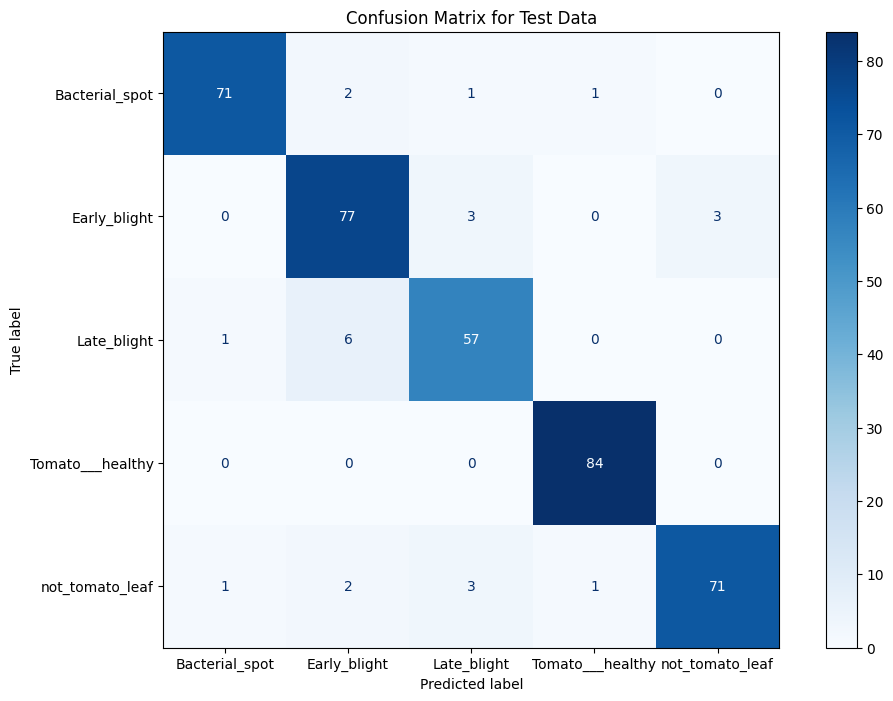

In [29]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

# Get true labels and predictions
true_labels = []
predicted_labels = []

for images_batch, labels_batch in test_ds:
    predictions = model.predict(images_batch)
    true_labels.extend(labels_batch.numpy())
    predicted_labels.extend(np.argmax(predictions, axis=1))

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)

# Calculate and print accuracy, precision, recall, and F1 score
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a figure with a custom size
plt.figure(figsize=(12, 8))  # Adjust the width and height as needed

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())

# Add title
plt.title("Confusion Matrix for Test Data")

# Show plot
plt.show()


In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 37, 'steps': 101}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
np.argmax([9.7385025e-01, 9.8620980e-08, 4.1836065e-02, 5.26107864e-02, 1.7318280e-09])

0

In [36]:
def predict(model, img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array, 0) #creates a batch
    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 30ms/step


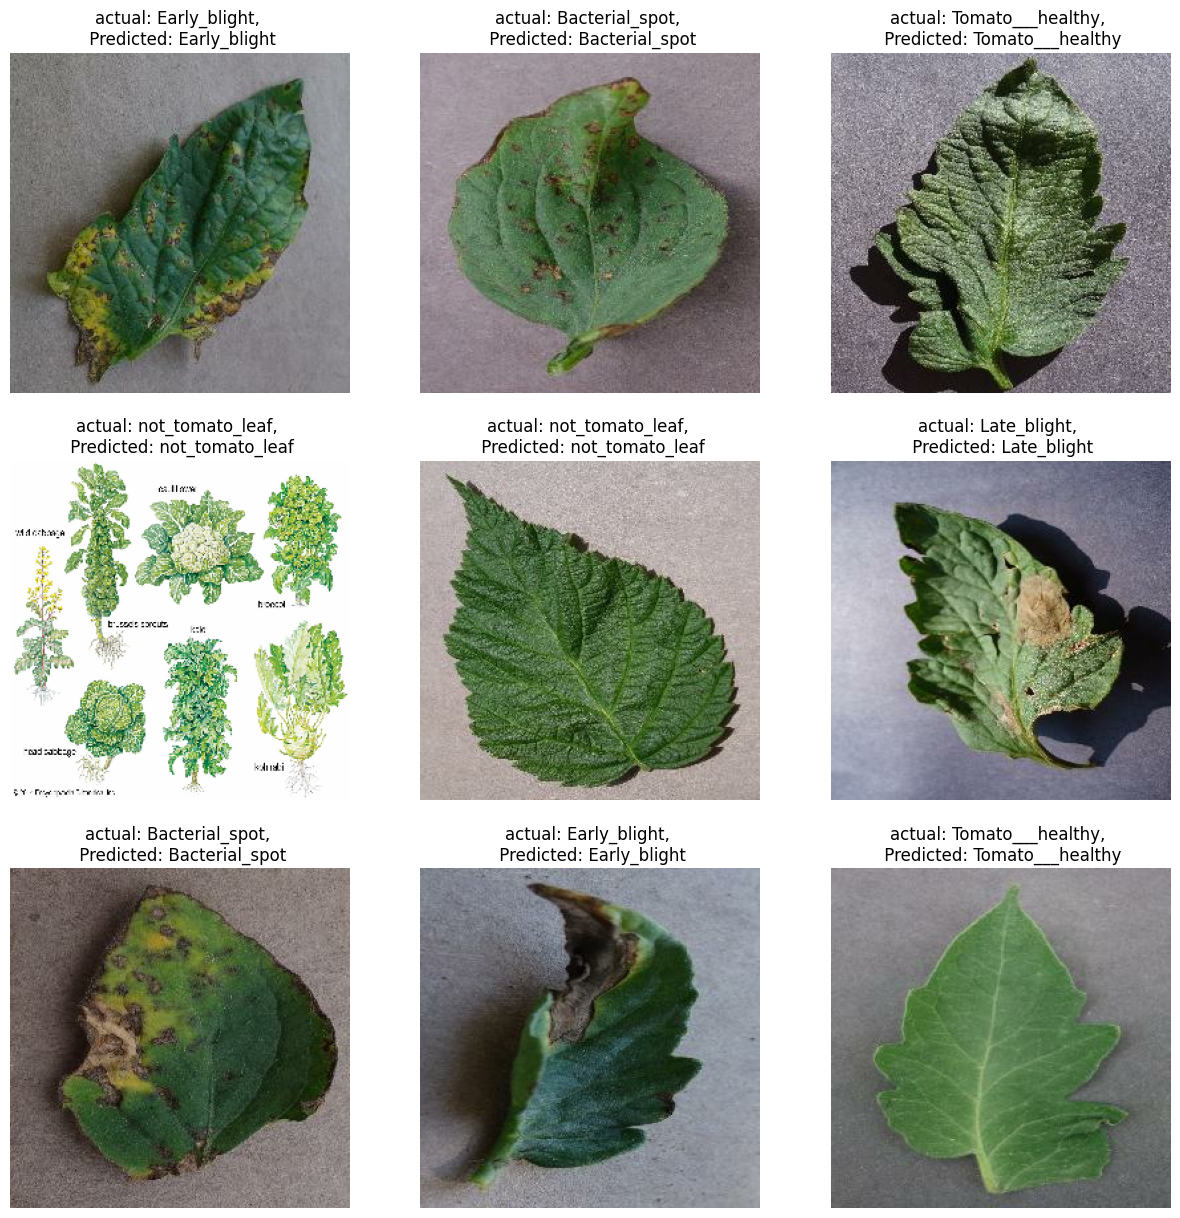

In [37]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax= plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence= predict(model, images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"actual: {actual_class}, \n Predicted: {predicted_class}")
        plt.axis("off")

In [38]:
#keras_file="linear.h5"
#keras.models.save_model(model, keras_file)
model.save('tomato_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load your trained model
model = load_model('model.h5')

In [39]:
converter=tf.lite.TFLiteConverter.from_keras_model(model)
tlite=converter.convert()

with open('converted_model.tflite', 'wb') as f:
    f.write(tlite)
print("completed")

completed


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image

import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [44]:
# Function to preprocess the image
def preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(256, 256))  # Assuming your model requires input size of 224x224
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [45]:
# Function to make predictions
def predict_disease(image_path):
    img_array = preprocess_image(image_path)
    prediction = model.predict(img_array)
    labels=['Bacterial_spot', 'Early_blight', 'Late_blight', 'Tomato___healthy', 'not_tomato_leaf']
    predicted_label = labels[np.argmax(prediction)]
    return predicted_label

In [47]:
# Example usage
image_path = '/content/worm_173.jpg'
  # Replace with the path to your image
predicted_label = predict_disease(image_path)
print("Predicted label:", predicted_label)

1/1 [==============================] - 0s 31ms/step
Predicted label: not_tomato_leaf
